# Locality Biases C: Scrambling 

In this notebook, we investigate disruptions in the global structure of images through random permutations in images patches and how they influence the classification accuracy of each neural net architecture. The goal is to create a manipulation of the CIFAR-10 test set which applied 4x4 patch scrambling to each 32x32 image in the testing set. 

The key idea here is that we want to gauge the performance drop of each model from the clean test set as they attempt to classify these scrambled images by focusing on the global arrangement of the patches rather than local image details, since the local cues will no longer be as reliable due to the scrambling. The hypothesis here is that models that rely heavily on local image features may struggle with the scrambled test set more than the models that can recognize more abstract and global patterns.

### Setup/Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from google.colab import files

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000, shuffle=False)

test_images, test_labels = next(iter(test_loader))

print(f'Test set size: {test_images.shape}') 

100%|██████████| 170498071/170498071 [00:05<00:00, 29494142.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Test set size: torch.Size([10000, 3, 32, 32])


### Scrambling 

We now define the `scramble_image` method to scramble the images by dividing them into 4x4 patches, randomly shuffling the images, and finally reconstructing the scrambled imaged from the shuffled patch sequence.

In [3]:
def scramble_image(image, patch_size=4):

    _, height, width = image.shape

    # extracting 4x4 patches from the image
    patches = []

    for i in range(0, height, patch_size):

        for j in range(0, width, patch_size):

            patches.append(image[:, i:i+patch_size, j:j+patch_size])

    # shuffling the 4x4 patches
    np.random.shuffle(patches)

    # scrambled image reconstruction
    scrambled_image = torch.zeros_like(image)
    patch_idx = 0
    
    for i in range(0, height, patch_size):
    
        for j in range(0, width, patch_size):
    
            scrambled_image[:, i:i+patch_size, j:j+patch_size] = patches[patch_idx]
            patch_idx += 1

    return scrambled_image

scrambled_images = torch.zeros_like(test_images)

for i in range(test_images.shape[0]):

    scrambled_images[i] = scramble_image(test_images[i])

print("Scrambling complete.")


Scrambling complete.


Visualization

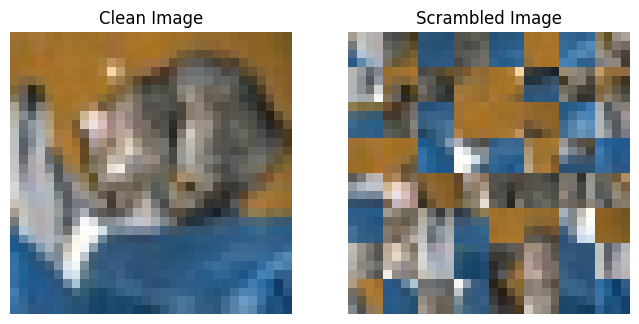

In [4]:
def imshow(clean_img, scrambled_img):

    _, axs = plt.subplots(1, 2, figsize=(8, 4))  

    npimg_clean = clean_img.numpy()
    axs[0].imshow(np.transpose(npimg_clean, (1, 2, 0)))
    axs[0].set_title("Clean Image")

    npimg_scrambled = scrambled_img.numpy()
    axs[1].imshow(np.transpose(npimg_scrambled, (1, 2, 0)))
    axs[1].set_title("Scrambled Image")

    for ax in axs:
        ax.axis('off')

    plt.show()

clean_image = test_images[0]
scrambled_image = scrambled_images[0]

imshow(clean_image, scrambled_image, titles=["Clean Image", "Scrambled Image"])


### Optional: Export Scrambled Test Set As Zip

In [5]:

output_dir = 'scrambled_cifar10_test'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def save_images(scrambled_images, labels, directory):

    classes = test_set.classes

    for idx, (img, label) in enumerate(zip(scrambled_images, labels)):

        class_name = classes[label]
        class_dir = os.path.join(directory, class_name)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        img_np = np.transpose(img.numpy(), (1, 2, 0))

        image_path = os.path.join(class_dir, f'{idx}.png')

        plt.imsave(image_path, img_np)

    print(f"All scrambled images saved in {directory}")

save_images(scrambled_images, test_labels, output_dir)
shutil.make_archive(output_dir, 'zip', output_dir)
files.download(f'{output_dir}.zip')


All scrambled images saved in scrambled_cifar10_test


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>